# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which image representation is best?](#repr)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which training sample is best?](#sample)
- [x] [Which categorisation is best?](#cat)
- [x] [Does vertex help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton energy help neutrino energy estimation?](#energy)
- [x] [Different sample energy estimation](#energy_samples)
- [ ] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: cosmic classification](#cosmic_calib)
- [ ] [Model calibration sensitivity: beam classification](#beam_calib)
- [ ] [Model calibration sensitivity: energy estimation](#energy_calib)
- [ ] [Clustering: cosmic classification](#cosmic_cluster)
- [ ] [Clustering: beam classification](#beam_cluster)
- [ ] [Explanation: cosmic classification](#cosmic_explain)
- [ ] [Explanation: beam classification](#beam_explain)
- [ ] [Explanation: energy estimation](#energy_explain)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/eval.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"
total_flux_events = 3200000
total_uniform_events = 2880000
total_cosmic_events = 800000

In [2]:
# Standard inports
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
both_ev, both_out = chipsnet.utils.evaluate(config, "both_cosmic")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux_cosmic")
uniform_ev, uniform_out = chipsnet.utils.evaluate(config, "uniform_cosmic")


************************ Evaluating both_cosmic ************************
Weights: (81284,0.00048), (31589,0.00008), (80647,0.04158), (31080,0.00236), (31400,38.55726)
Cuts:    (85069,1.00000), (85031,1.00000), (54500,1.00000), (31400,1.00000)
took 46.58 seconds

************************ Evaluating flux_cosmic ************************
Weights: (51826,0.00075), (51601,0.00005), (50912,0.06586), (50461,0.00145), (51200,23.64644)
Cuts:    (87566,1.00000), (87395,1.00000), (29839,1.00000), (51200,1.00000)
took 46.09 seconds

************************ Evaluating uniform_cosmic ************************
Weights: (96719,0.00040), (0,0.00000), (96483,0.03475), (0,0.00000), (62798,19.27924)
Cuts:    (62795,1.00000), (62798,1.00000), (67609,1.00000), (62798,1.00000)
took 49.70 seconds


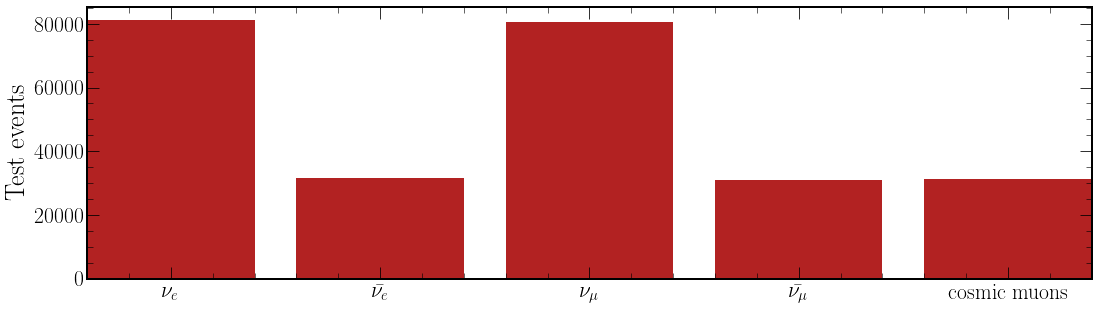

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(both_ev[(both_ev.t_nu_type == 0) & (both_ev.t_sign_type == 0) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 0) & (both_ev.t_sign_type == 1) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 1) & (both_ev.t_sign_type == 0) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 1) & (both_ev.t_sign_type == 1) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[both_ev.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic muons'))
axs.set_ylabel("Test events")
chipsnet.plotting.save(save_path + "nu_types")

In [6]:
def plot_training_sample(events, scale, save_name):
    data = [
        len(events[events["t_nu_nc_cat"] == i])
        for i in range(len(chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]))
    ]
    del data[16]
    data = [x * scale for x in data]

    labels = chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]
    del labels[16]
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 5), gridspec_kw={"hspace": 0.3})
    axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black')
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=14, rotation="vertical")
    axs.set_ylabel("Training events")
    axs.set_yscale('log')
    #axs.set_ylim(20e3, 10e5)
    chipsnet.plotting.save(save_name)

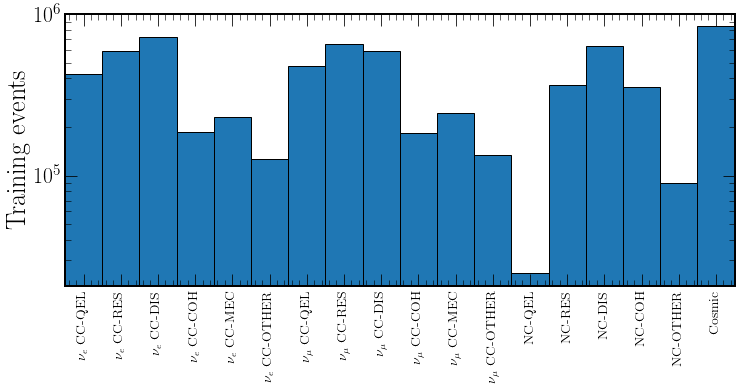

In [7]:
plot_training_sample(both_ev, (total_flux_events+total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "both_sample")

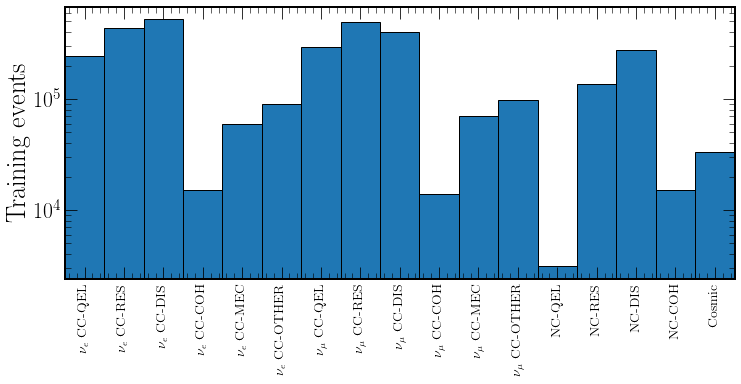

In [8]:
plot_training_sample(flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, save_path + "flux_sample")

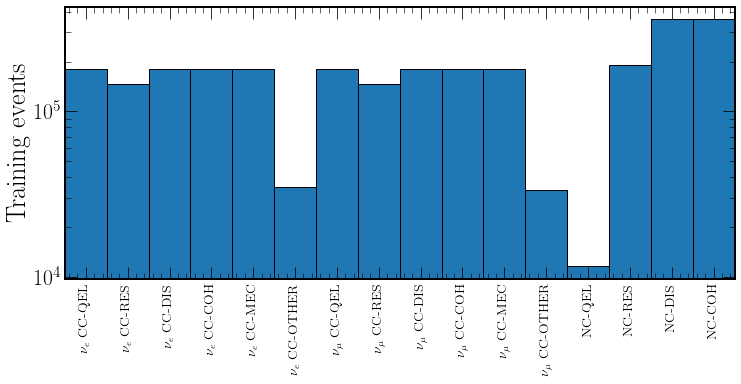

In [9]:
plot_training_sample(uniform_ev, (total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "uniform_sample")

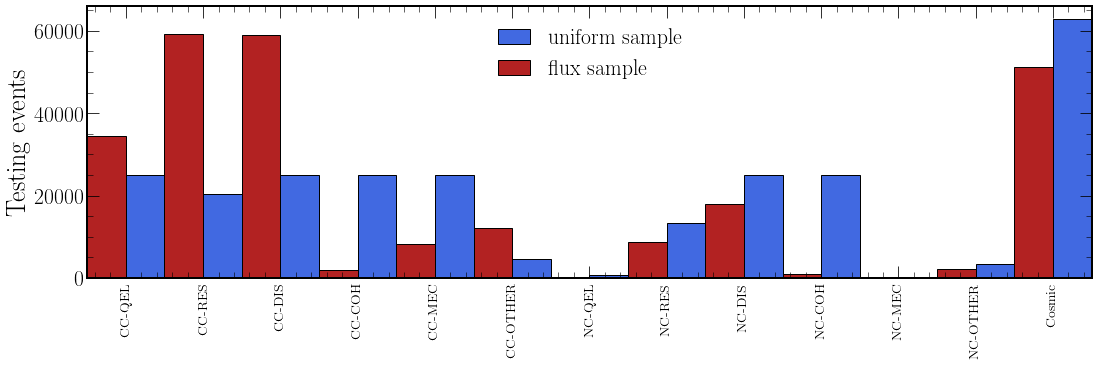

In [10]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_INT_TYPE, save_path)

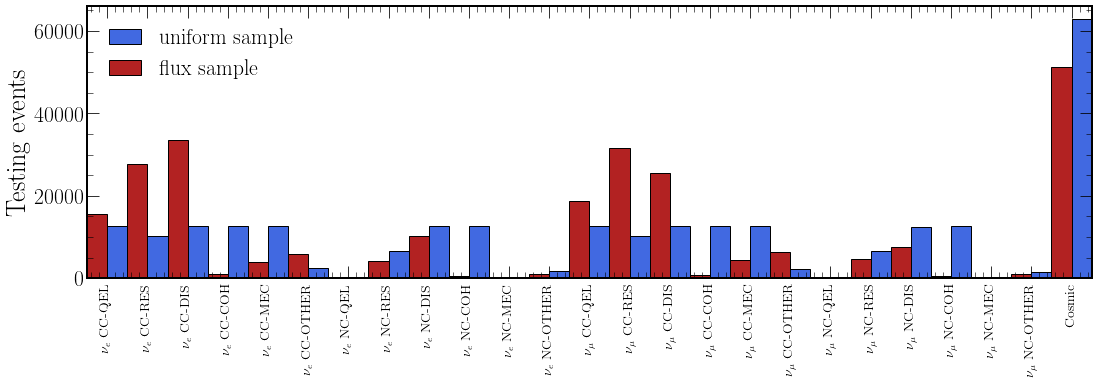

In [11]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_ALL_CAT, save_path)

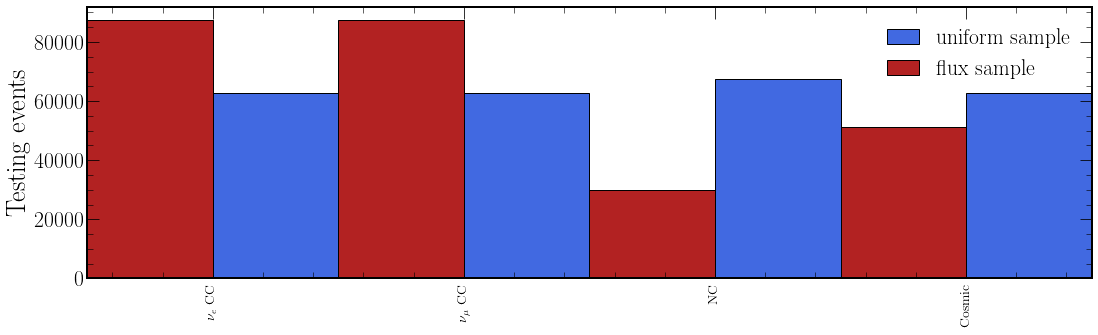

In [12]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

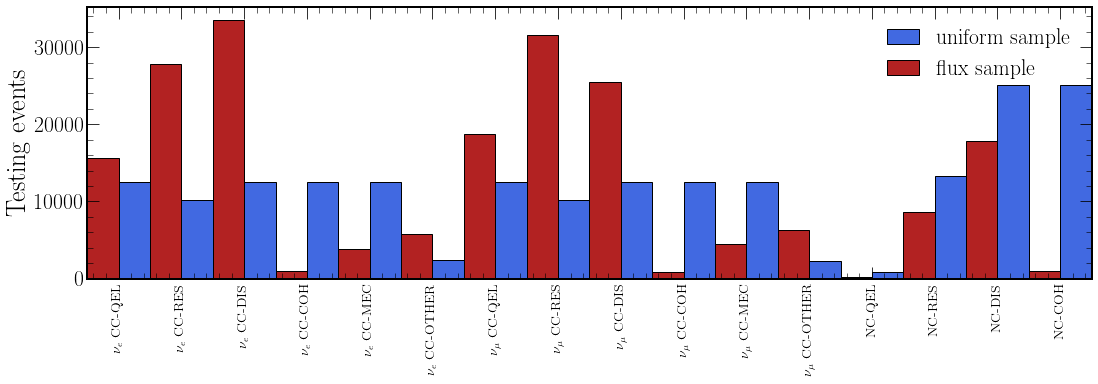

In [13]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_NU_NC_COMB_CAT, save_path)

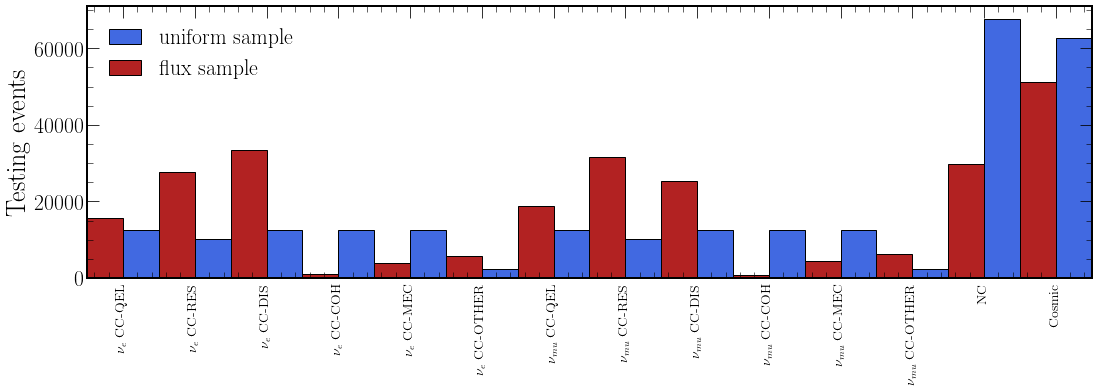

In [14]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_NC_COMB_CAT, save_path)

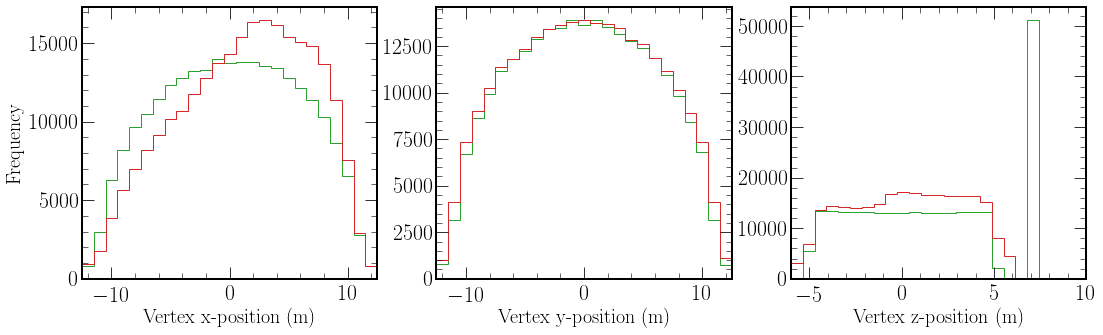

In [15]:
line_g = matplotlib.lines.Line2D([], [], c='tab:green')
line_r = matplotlib.lines.Line2D([], [], c='tab:red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev["t_vtx_x"]/100, range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step')
axs[0].hist(flux_ev["r_vtx_x"]*1250/100, range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(flux_ev["t_vtx_y"]/100, range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step')
axs[1].hist(flux_ev["r_vtx_y"]*1250/100, range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(flux_ev["t_vtx_z"]/100, range=(-6, 10), bins=25, color='tab:green', histtype='step')
axs[2].hist(flux_ev["r_vtx_z"]*600/100, range=(-6, 10), bins=25, color='tab:red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
chipsnet.plotting.save(save_path + "vtx_positions")

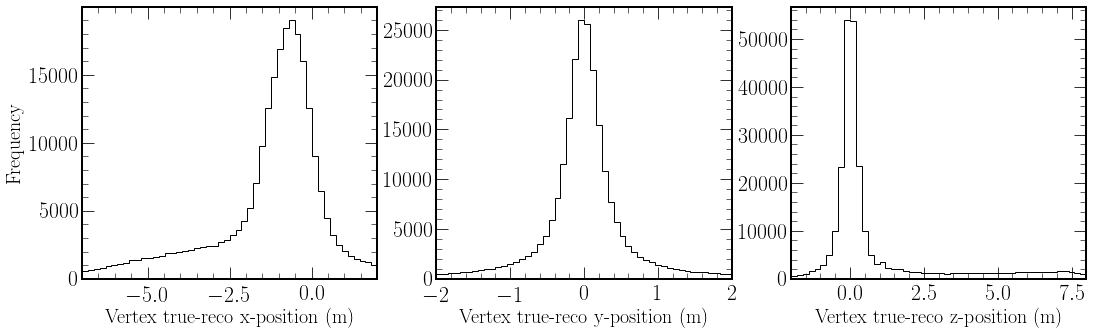

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev["t_vtx_x"]/100-(flux_ev["r_vtx_x"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(flux_ev["t_vtx_y"]/100-(flux_ev["r_vtx_y"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(flux_ev["t_vtx_z"]/100-(flux_ev["r_vtx_z"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
chipsnet.plotting.save(save_path + "true_reco_vtx")

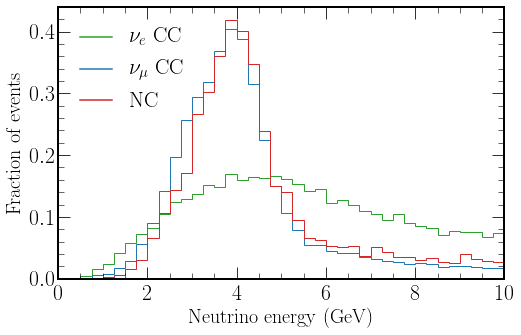

In [17]:
line_g = matplotlib.lines.Line2D([], [], c='tab:green')
line_b = matplotlib.lines.Line2D([], [], c='tab:blue')
line_r = matplotlib.lines.Line2D([], [], c='tab:red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"],
         range=(0, 10), bins=40, color='tab:green', histtype='step', density=True)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=40, color='tab:blue', histtype='step', density=True)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=40, color='tab:red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["$\\nu_{e}$ CC", "$\\nu_{\mu}$ CC", "NC"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
chipsnet.plotting.save(save_path + "nu_energies")

In [18]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4710996195164194


1


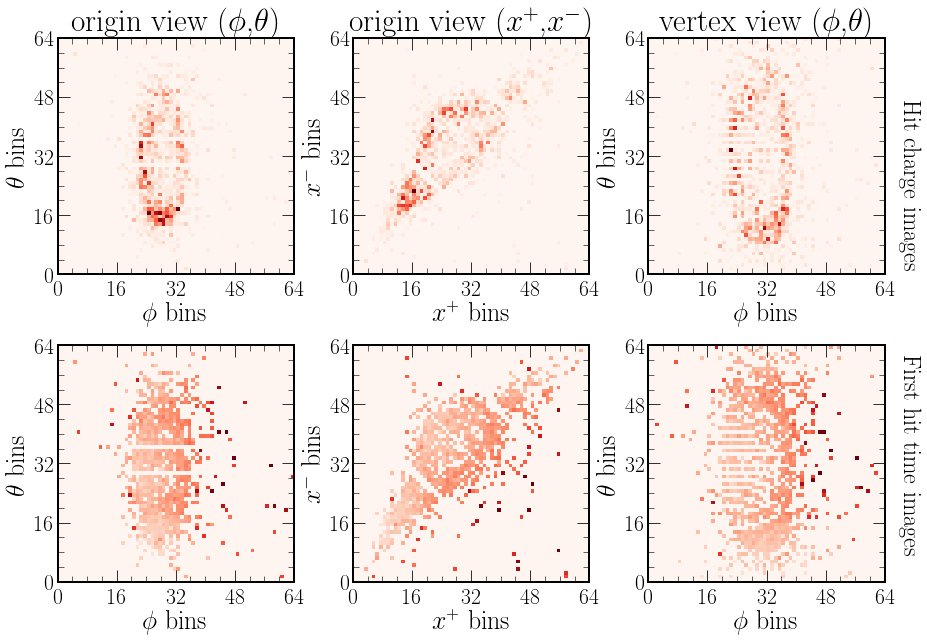

In [19]:
print(true_dict["t_code"][41])
chipsnet.plotting.plot_hit_time(images_dict, 41, save_path+"nuel_ccqel_event")

91


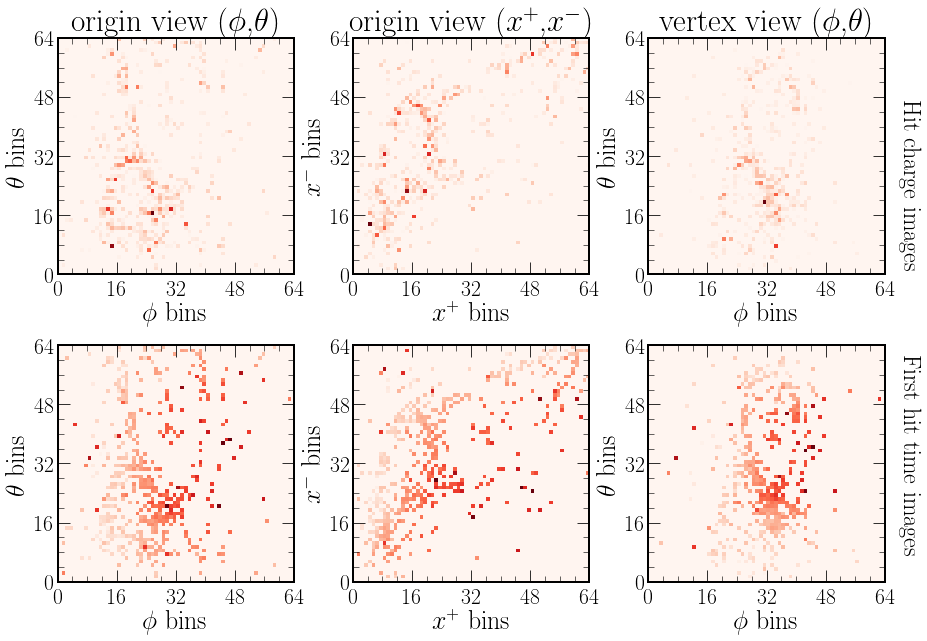

In [20]:
print(true_dict["t_code"][2037])
chipsnet.plotting.plot_hit_time(images_dict, 2037, save_path+"numu_ccdis_event")

100


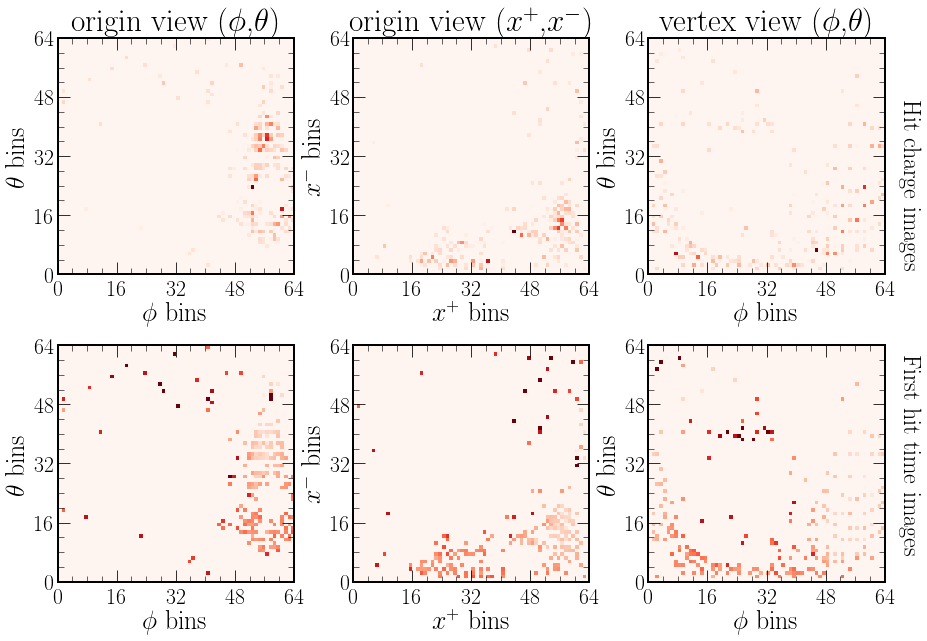

In [21]:
print(true_dict["t_code"][4017])
chipsnet.plotting.plot_hit_time(images_dict, 4017, save_path+"cosmic_event")

92


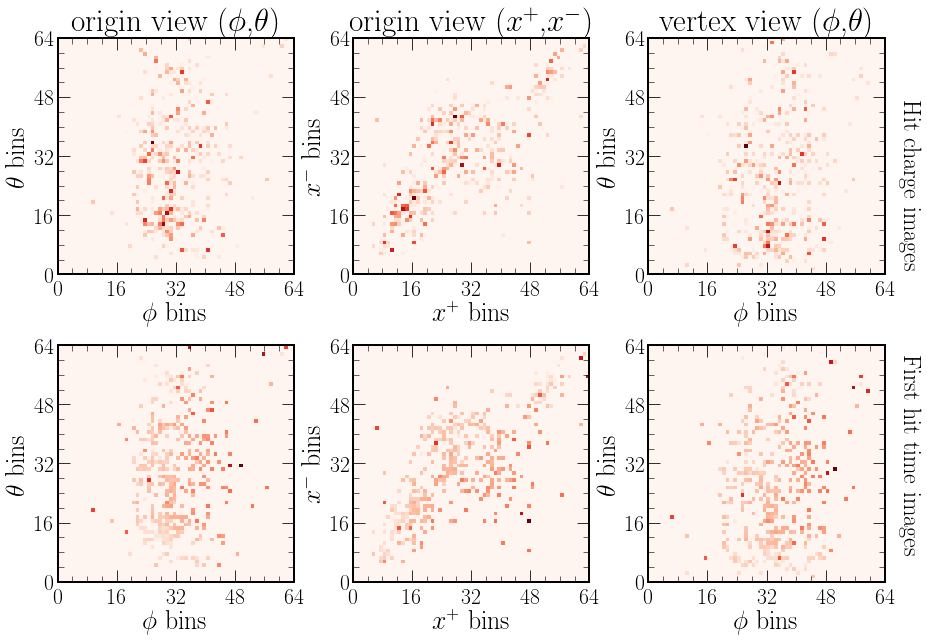

In [22]:
print(true_dict["t_code"][2031])
chipsnet.plotting.plot_hit_time(images_dict, 2031, save_path+"numu_ncdis_event")

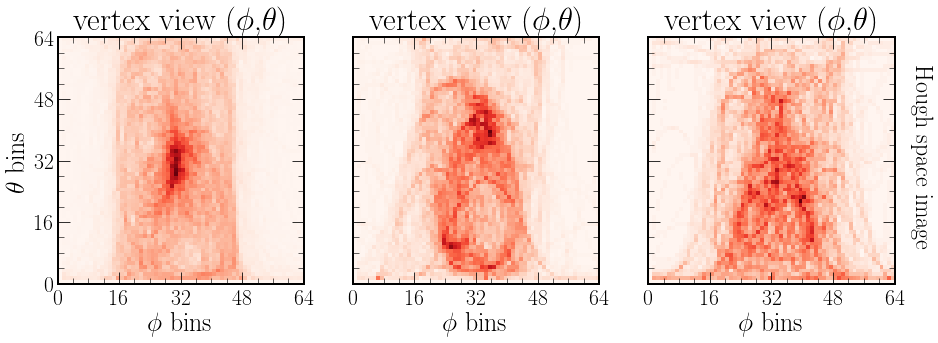

In [23]:
chipsnet.plotting.plot_hough(images_dict, [41, 2037, 2031], save_path+"hough_events")

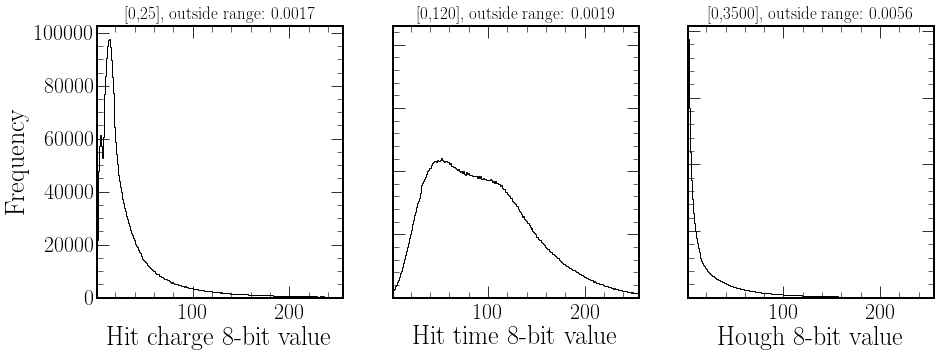

In [24]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

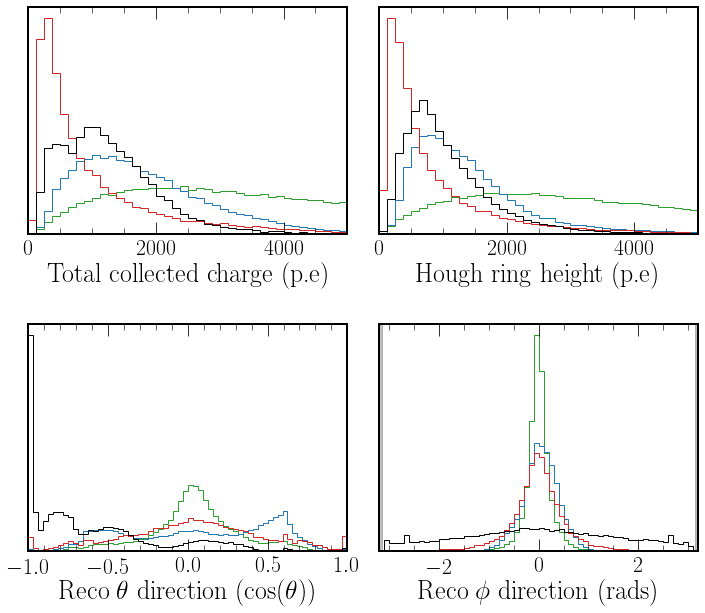

In [25]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [26]:
# Tidy up
del both_ev, both_out
del flux_ev, flux_out
del uniform_ev, uniform_out
del images_dict

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It does seem to do this by sacrificing a bit of purity for greater efficiency, but overall its still better.
* The fact that both origin view representations are similar, hints that the parameterisation is less important and where you view the interaction from is key.

In [27]:
v_ev, v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_nu_nc_cat"])  # Vertex theta/phi repr
o_ev, o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_nu_nc_cat"])  # Origin theta/phi repr
i_ev, i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_nu_nc_cat"])  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Weights: (64766,0.00060), (64628,0.00004), (63591,0.05273), (63015,0.00116), (0,0.00000)
Cuts:    (109642,1.00000), (109080,1.00000), (37278,1.00000), (0,0.00000)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 18, does not match size of target_names, 16
  warnings.warn(



------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94594,0.62703), Rec: (0.90586,0.87953), F1: (0.92177,0.66991)
- Cat->  Prec: (0.56218,0.25829), Rec: (0.51349,0.36055), F1: (0.50439,0.23865)
- Nuel-> ROC-AUC: 0.98395, PRC-AUC: 0.58818, S-Eff: 0.89490, S-Pur: 0.18803
- FOM1-> 0.31741, 0.94000, 21.31686, 11.91817, 7.35194, 0.60434, 0.52521
- FOM2-> 6.75070, 0.99500, 8.35054, 0.97361, 0.55653, 0.23674, 0.84514
- Numu-> ROC-AUC: 0.97916, PRC-AUC: 0.99650, S-Eff: 0.91545, S-Pur: 0.99240
- FOM1-> 0.93540, 0.06500, 2.55168, 2865.90593, 94.30386, 0.96701, 0.96731
- FOM2-> 2392.26378, 0.99500, 0.03292, 2226.97861, 0.83367, 0.75142, 0.99961
took 255.56 seconds

************************ Evaluating o_ct_flux ************************
Weights: (65149,0.00060), (63993,0.00004), (63988,0.05240), (62870,0.00117), (0,0.00000)
Cuts:    (109276,1.00000), (109425,1.00000), (37299,1.00000), (0,0.00000)

------------------------ repr_o_ct report ------------------------
-

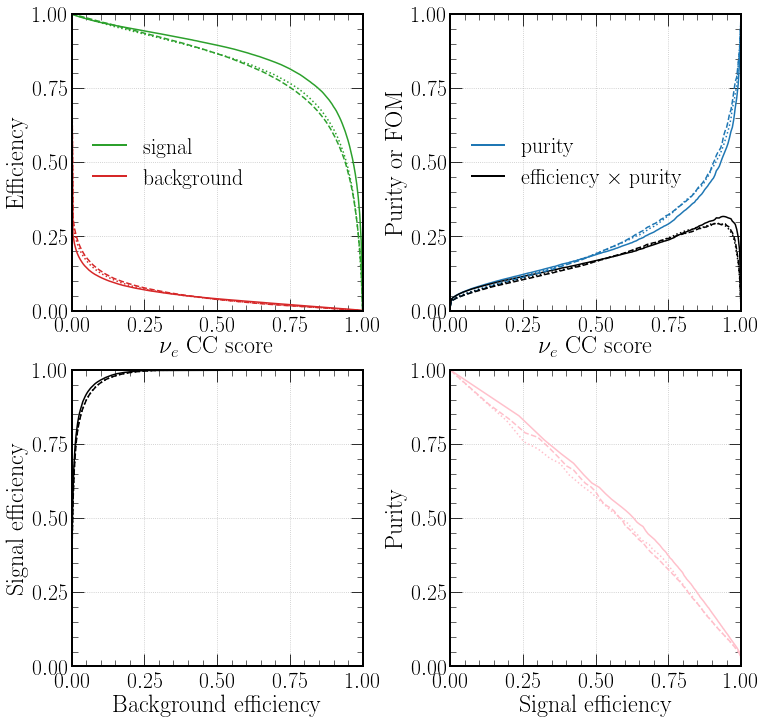

In [28]:
chipsnet.plotting.plot_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_curves")

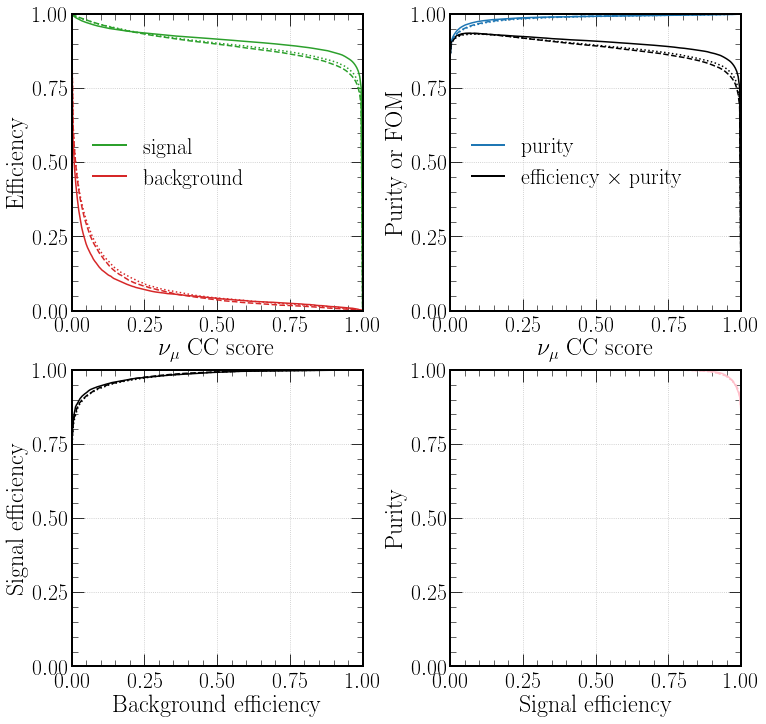

In [29]:
chipsnet.plotting.plot_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_curves")

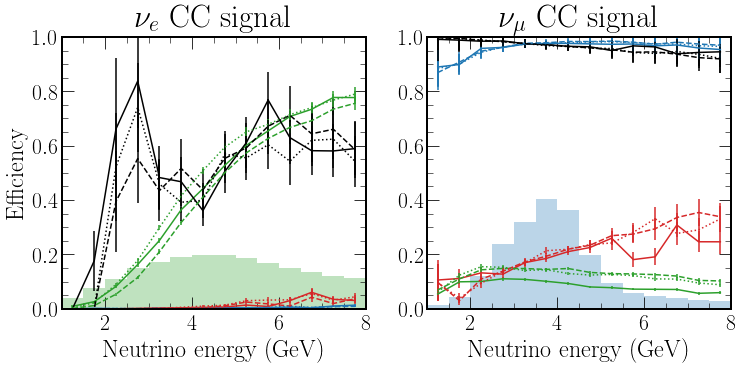

In [30]:
chipsnet.plotting.plot_e_hists([v_out[0], o_out[0], i_out[0]], v_ev, save_path+"repr_hists")

In [31]:
# Tidy up
del v_ev, v_out
del o_ev, o_out
del i_ev, i_out

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [32]:
c_ev, c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_nu_nc_cat"])  # Just charge channel
ct_ev, ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_nu_nc_cat"])  # Charge+time channels
cth_ev, cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_nu_nc_cat"])  # Charge+time+hough channels
cth_stacked_ev, cth_stacked_out = chipsnet.utils.evaluate(config,"v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_nu_nc_cat"])  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Weights: (64766,0.00060), (64628,0.00004), (63591,0.05273), (63015,0.00116), (0,0.00000)
Cuts:    (109642,1.00000), (109080,1.00000), (37278,1.00000), (0,0.00000)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 18, does not match size of target_names, 16
  warnings.warn(



------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.94397,0.62090), Rec: (0.90080,0.87488), F1: (0.91811,0.66095)
- Cat->  Prec: (0.55871,0.30805), Rec: (0.50331,0.35028), F1: (0.49336,0.22650)
- Nuel-> ROC-AUC: 0.98313, PRC-AUC: 0.57783, S-Eff: 0.89801, S-Pur: 0.17594
- FOM1-> 0.31372, 0.93500, 21.78359, 13.01936, 8.07862, 0.61758, 0.50799
- FOM2-> 6.38451, 0.99500, 7.88350, 0.92204, 0.60266, 0.22350, 0.83794
- Numu-> ROC-AUC: 0.97507, PRC-AUC: 0.99582, S-Eff: 0.91161, S-Pur: 0.99141
- FOM1-> 0.92752, 0.07000, 2.37727, 2851.62383, 104.22563, 0.96219, 0.96396
- FOM2-> 2146.31461, 0.99500, 0.03968, 2248.19922, 1.05751, 0.75858, 0.99951
took 231.16 seconds

************************ Evaluating v_ct_flux ************************
Weights: (64766,0.00060), (64628,0.00004), (63591,0.05273), (63015,0.00116), (0,0.00000)
Cuts:    (109642,1.00000), (109080,1.00000), (37278,1.00000), (0,0.00000)

------------------------ repr_v_ct report ------------------------
-

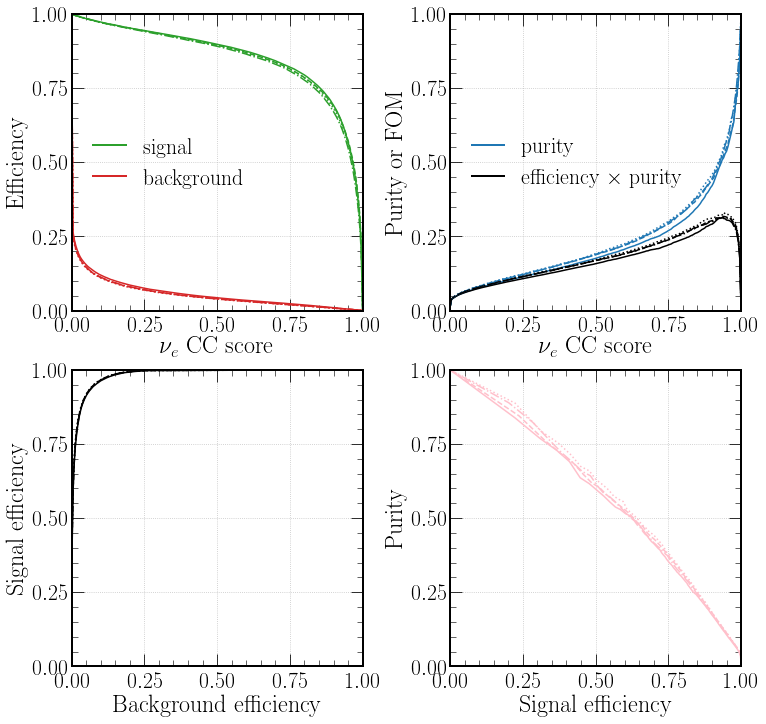

In [33]:
chipsnet.plotting.plot_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_curves")

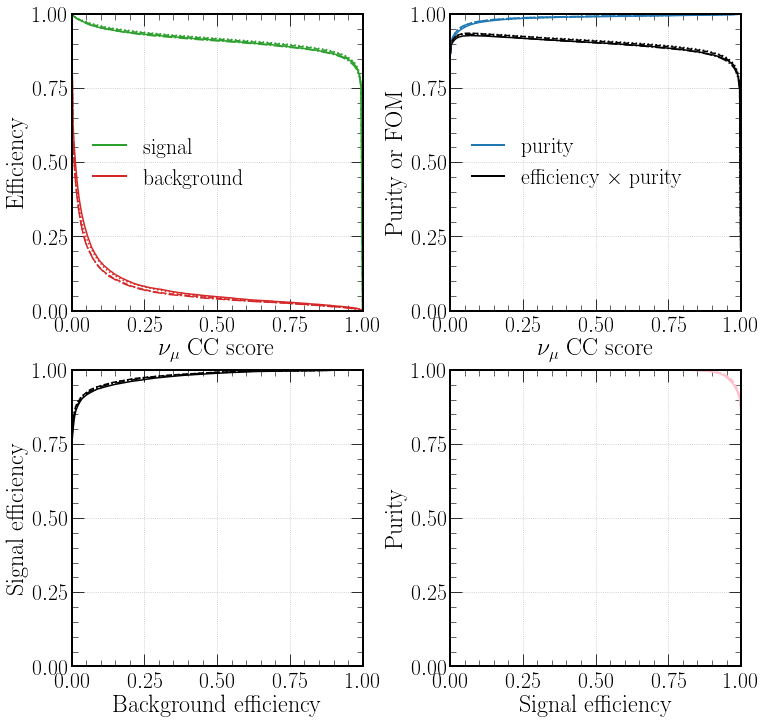

In [34]:
chipsnet.plotting.plot_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_curves")

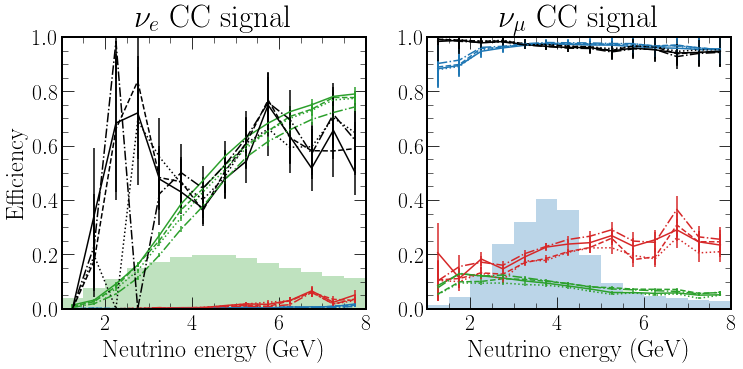

In [35]:
chipsnet.plotting.plot_e_hists([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], c_ev, save_path+"channel_hists")

In [36]:
# Tidy up
del c_ev, c_out
del ct_ev, ct_out
del cth_ev, cth_out
del cth_stacked_ev, cth_stacked_out

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample you use and its relative number of events for each category makes a significant difference to performance.
* As expected training on a beam flux distribution is much better than a uniform sample.
* Bolstering the underepresented categories in the beam flux however leads to much better performance in seperating CC and NC types.

In [37]:
events, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_nu_nc_cat", "t_nu_nc_cat", "t_nu_nc_cat"]
)


************************ Evaluating flux ************************
Weights: (64766,0.00060), (64628,0.00004), (63591,0.05273), (63015,0.00116), (0,0.00000)
Cuts:    (109642,1.00000), (109080,1.00000), (37278,1.00000), (0,0.00000)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 18, does not match size of target_names, 16
  warnings.warn(



------------------------ sample_both report ------------------------
- Comb-> Prec: (0.94606,0.62953), Rec: (0.90749,0.87895), F1: (0.92285,0.67221)
- Cat->  Prec: (0.56505,0.31437), Rec: (0.51234,0.36324), F1: (0.50705,0.24116)
- Nuel-> ROC-AUC: 0.98433, PRC-AUC: 0.60305, S-Eff: 0.89378, S-Pur: 0.19181
- FOM1-> 0.33068, 0.94000, 20.98109, 9.32271, 7.43733, 0.59482, 0.55592
- FOM2-> 7.89387, 0.99500, 7.89335, 0.71228, 0.28759, 0.22378, 0.88757
- Numu-> ROC-AUC: 0.97874, PRC-AUC: 0.99643, S-Eff: 0.91783, S-Pur: 0.99184
- FOM1-> 0.93470, 0.08500, 2.06491, 2857.23078, 87.75804, 0.96408, 0.96952
- FOM2-> 2125.84170, 0.99500, 0.03688, 2265.00153, 1.09833, 0.76425, 0.99950

------------------------ sample_flux report ------------------------
- Comb-> Prec: (0.94632,0.63193), Rec: (0.90778,0.87173), F1: (0.92361,0.66560)
- Cat->  Prec: (0.55569,0.26925), Rec: (0.54311,0.30737), F1: (0.52536,0.23276)
- Nuel-> ROC-AUC: 0.98443, PRC-AUC: 0.58701, S-Eff: 0.90977, S-Pur: 0.17804
- FOM1-> 0.33260,

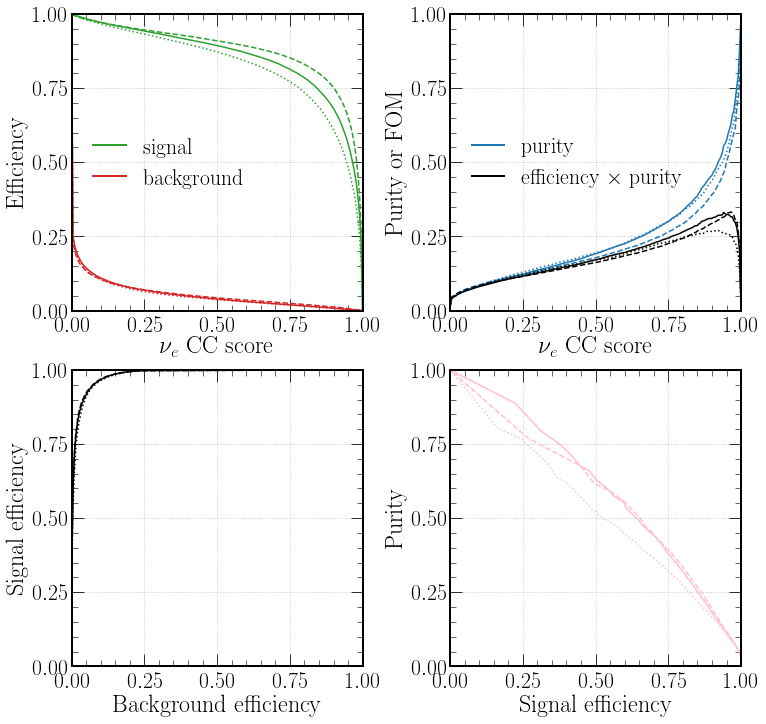

In [38]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_curves")

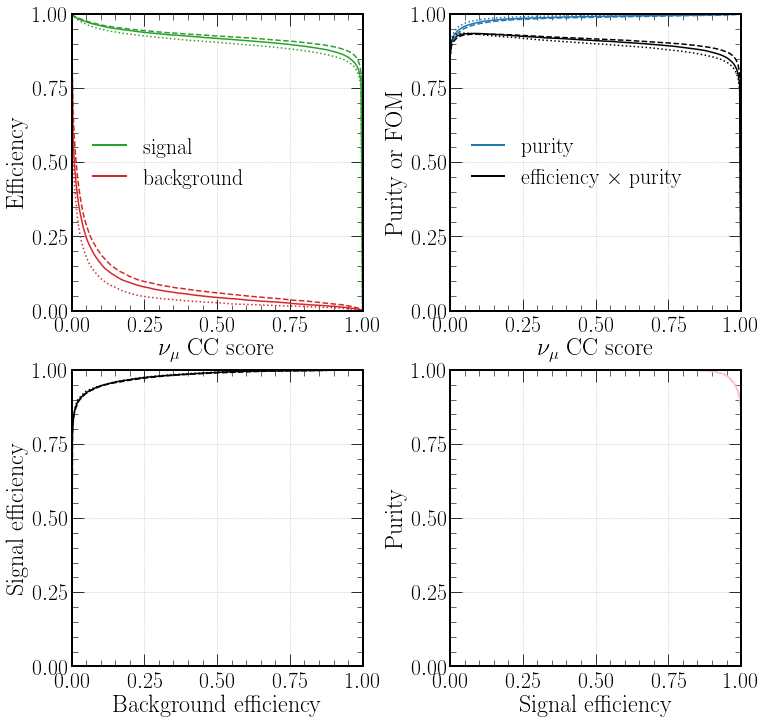

In [39]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_curves")

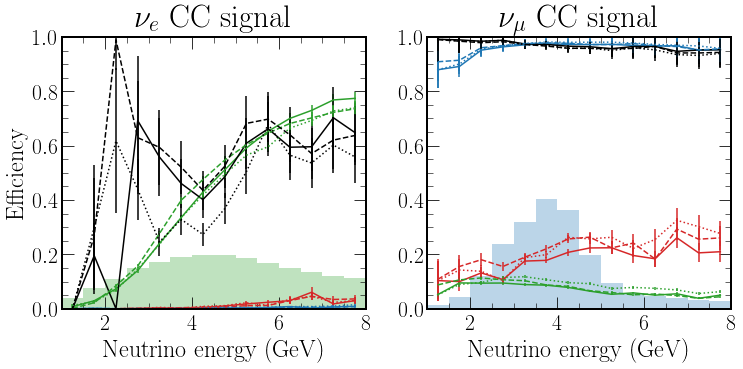

In [40]:
chipsnet.plotting.plot_e_hists([outputs[0], outputs[1], outputs[2]], events, save_path+"sample_hists")

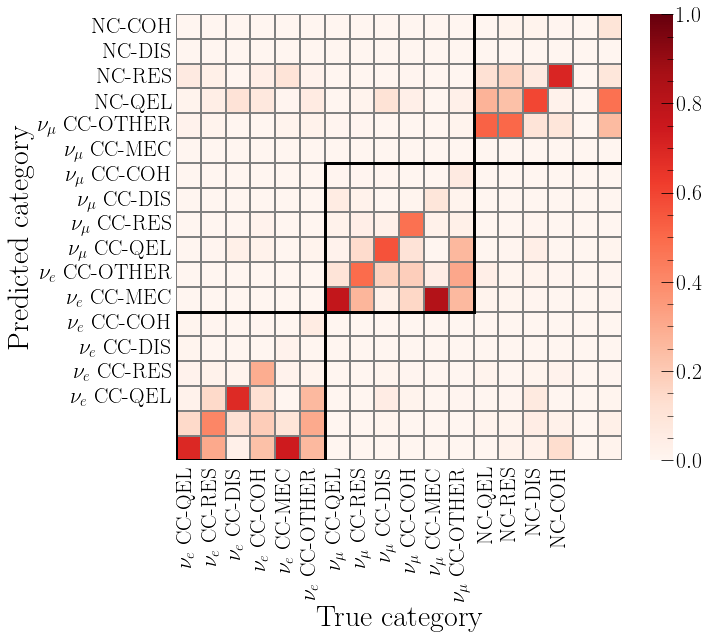

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18],
    yticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 12), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 6), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

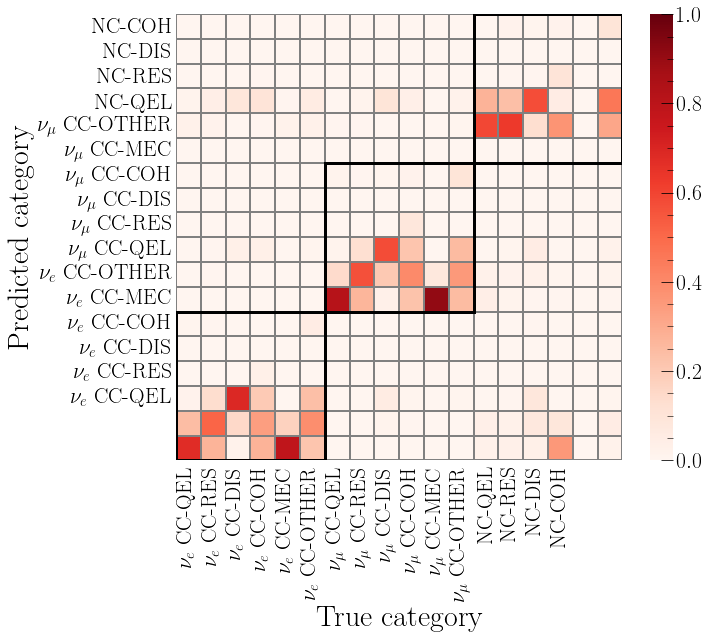

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18],
    yticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 12), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 6), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

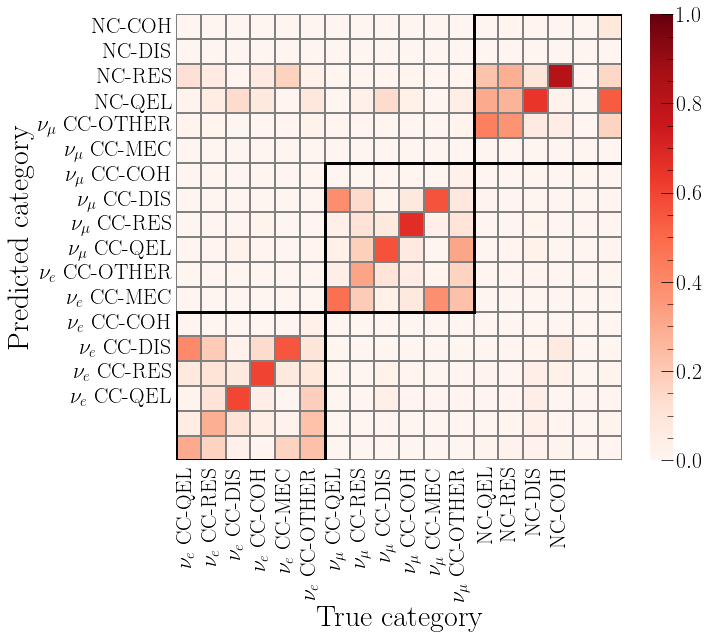

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18],
    yticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][:18][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 12), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 6), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [44]:
# Tidy up
del events, outputs

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_nu_nc_cat" maybe this is still reasonable to use to simplify other studies

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_final_cat", "cat_t_all_cat", "cat_t_comb_cat", "cat_t_nu_nc_cat", "cat_t_nc_cat", "cat_split", "cat_split_learn"], 
    ["t_final_cat", "t_all_cat", "t_comb_cat", "t_nu_nc_cat", "t_nc_cat", "t_comb_cat", "t_comb_cat"]
)


************************ Evaluating flux ************************


In [ ]:
chipsnet.plotting.plot_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 0, save_path+"cat_nuel_curves")

In [ ]:
chipsnet.plotting.plot_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 1, save_path+"cat_numu_curves")

In [ ]:
chipsnet.plotting.plot_e_hists([outputs[3], outputs[0], outputs[1], outputs[5]], events, save_path+"cat_hists")

In [ ]:
# Tidy up
del events, outputs

<a id='cosmic'></a>

## Does vertex help cosmic classifier? (cosmic)
* Can't really come to a full conclusion without knowing if the events that pass will contaminate our signal
* Looks like adding the vertex position and time, makes the average values better, by the number of events that get accepted gets worse.

In [ ]:
events, outputs = chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic"], ["t_cosmic_cat"])
events, outputs = chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic_vtx"], ["t_cosmic_cat"])
events, outputs = chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic_vtx_learn"], ["t_cosmic_cat"])

In [ ]:
# Tidy up
del events, outputs

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense
* The "learned" version of the multitask weights seems to work best.
* Still need to combine with the correct category type to see if that has a different effect.

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_nu_nc_cat", "t_nu_nc_cat", "t_nu_nc_cat"]
)

In [ ]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_curves")

In [ ]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_curves")

In [ ]:
chipsnet.plotting.plot_e_hists([outputs[0], outputs[1], outputs[2]], events, save_path+"beam_hists")

In [ ]:
# Tidy up
del events, outputs

<a id='energy'></a>

## Does lepton energy help neutrino energy estimation? (energy)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "flux",
    ["energy", "lepton", "energy_lepton", "energy_lepton_learn"],
    ["energy", "energy", "energy", "energy"]
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_frac_nu_energy")
axs[0].plot(e_list, std_list, color="tab:blue")
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_lepton_frac_nu_energy")
axs[0].plot(e_list, std_list, color="tab:orange")
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_lepton_learn_frac_nu_energy")
axs[0].plot(e_list, std_list, color="tab:purple")
axs[0].label_outer()
axs[0].set(ylabel=r"(True-reco)/true $\nu$ E", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.1, 0.4)
axs[0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="lepton_frac_lep_energy")
axs[1].plot(e_list, std_list, color="tab:blue")
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="energy_lepton_frac_lep_energy")
axs[1].plot(e_list, std_list, color="tab:orange")
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="energy_lepton_learn_frac_lep_energy")
axs[1].plot(e_list, std_list, color="tab:purple")
axs[1].label_outer()
axs[1].set(ylabel=r"(True-reco)/true lepton E", xlabel=r"lepton energy (MeV)")
axs[1].set_ylim(0.1, 0.4)
axs[1].grid()
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="single")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="multi1")
multi_learn = Line2D([0], [0], color="tab:purple", linewidth=2, linestyle="solid", label="multi2")
axs[1].legend(handles=[single, multi, multi_learn], loc="upper right")
chipsnet.plotting.save(save_path + "energy_frac_vs_e")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"], 
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:blue"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_lepton_frac_nu_energy'],
    weights=events[events["t_comb_cat"] == 0]["w"], 
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:orange"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:purple"
)
axs[0].set(xlabel=r"(True-reco)/true $\nu$ E", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 4.5)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['lepton_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:blue"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_lepton_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:orange"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.3, 0.3), bins=25, histtype='step', color="tab:purple"
)
axs[1].set(xlabel=r"(True-reco)/true lepton E", ylabel=r"Events (arb.)")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 4.5)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="single")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="multi1")
multi_learn = Line2D([0], [0], color="tab:purple", linewidth=2, linestyle="solid", label="multi2")
axs[1].legend(handles=[single, multi, multi_learn], loc="upper right")
chipsnet.plotting.save(save_path + "energy_frac_dist")

In [ ]:
print(events[events["t_comb_cat"] == 0]['energy_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_lepton_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_nu_energy'].describe())

In [ ]:
# Tidy up
del events, outputs

<a id='energy_samples'></a>

## Different sample energy estimation (energy_samples)
* The vertex location for muon events greatly effects the energy reconstruction performance due to not being fully contained.
* Can reach 5% energy resolution of QEL and MEC electrons.
* Lots of the DIS/RES are not having their true lepton energy found which is odd.

In [ ]:
# All the different interaction type samples and associated models
nuel_cccoh_ev, outs = chipsnet.utils.evaluate(config, "nuel_cccoh", ["nuel_cccoh_energy"], ["energy"])
nuel_ccdis_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccdis", ["nuel_ccdis_energy"], ["energy"])
nuel_ccqel_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccqel", ["nuel_ccqel_energy"], ["energy"])
nuel_ccres_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccres", ["nuel_ccres_energy"], ["energy"])
nuel_ccmec_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccmec", ["nuel_ccmec_energy"], ["energy"])
nuel_ccqelmec_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccqelmec", ["nuel_ccqelmec_energy"], ["energy"])
numu_cccoh_ev, outs = chipsnet.utils.evaluate(config, "numu_cccoh", ["numu_cccoh_energy"], ["energy"])
numu_ccdis_ev, outs = chipsnet.utils.evaluate(config, "numu_ccdis", ["numu_ccdis_energy"], ["energy"])
numu_ccqel_ev, outs = chipsnet.utils.evaluate(config, "numu_ccqel", ["numu_ccqel_energy"], ["energy"])
numu_ccres_ev, outs = chipsnet.utils.evaluate(config, "numu_ccres", ["numu_ccres_energy"], ["energy"])
numu_ccmec_ev, outs = chipsnet.utils.evaluate(config, "numu_ccmec", ["numu_ccmec_energy"], ["energy"])
numu_ccqelmec_ev, outs = chipsnet.utils.evaluate(config, "numu_ccqelmec", ["numu_ccqelmec_energy"], ["energy"])
flux_ev, outs = chipsnet.utils.evaluate(config, "flux", ["nuel_cc_energy", "numu_cc_energy", "nc_energy"], ["energy", "energy", "energy"])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
axs[0].hist(nuel_ccqel_ev['t_nu_energy'], range=(0, 10000), bins=25, histtype='step', color="tab:blue")
axs[0].hist(nuel_ccqel_ev['nuel_ccqel_energy_pred_t_nu_energy'], range=(0, 10000), bins=25, histtype='step', color="tab:orange")
axs[0].set(xlabel=r"$\nu$ energy (MeV)", ylabel=r"Events")
axs[0].label_outer()
axs[0].set_ylim(0, 1600)
axs[1].hist(nuel_ccqel_ev['t_lep_energy'], range=(0, 10000), bins=25, histtype='step', color="tab:blue")
axs[1].hist(nuel_ccqel_ev['nuel_ccqel_energy_pred_t_lep_energy'], range=(0, 10000), bins=25, histtype='step', color="tab:orange")
axs[1].set(xlabel=r"lepton energy (MeV)", ylabel=r"Events")
axs[1].label_outer()
axs[1].set_ylim(0, 1600)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_samples_dists")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0, 0].hist2d(nuel_cccoh_ev["t_nu_energy"], nuel_cccoh_ev["nuel_cccoh_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"Reco energy (MeV)")
axs[0, 0].set_title(r"nuel")
axs[1, 0].hist2d(nuel_ccdis_ev["t_nu_energy"], nuel_ccdis_ev["nuel_ccdis_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"Reco energy (MeV)")
axs[2, 0].hist2d(nuel_ccqel_ev["t_nu_energy"], nuel_ccqel_ev["nuel_ccqel_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"Reco energy (MeV)")
axs[3, 0].hist2d(nuel_ccres_ev["t_nu_energy"], nuel_ccres_ev["nuel_ccres_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 0].grid()
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"Reco energy (MeV)")
axs[4, 0].hist2d(nuel_ccmec_ev["t_nu_energy"], nuel_ccmec_ev["nuel_ccmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[4, 0].grid()
axs[4, 0].label_outer()
axs[5, 0].hist2d(nuel_ccqelmec_ev["t_nu_energy"], nuel_ccqelmec_ev["nuel_ccqelmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[5, 0].grid()
axs[5, 0].label_outer()
axs[5, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[5, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0, 1].hist2d(numu_cccoh_ev["t_nu_energy"], numu_cccoh_ev["numu_cccoh_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 2250, "CC-COH", rotation=-90)
axs[1, 1].hist2d(numu_ccdis_ev["t_nu_energy"], numu_ccdis_ev["numu_ccdis_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8000, 2250, "CC-DIS", rotation=-90)
axs[2, 1].hist2d(numu_ccqel_ev["t_nu_energy"], numu_ccqel_ev["numu_ccqel_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8000, 2250, "CC-QEL", rotation=-90)
axs[3, 1].hist2d(numu_ccres_ev["t_nu_energy"], numu_ccres_ev["numu_ccres_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 1].grid()
axs[3, 1].label_outer()
axs[3, 1].text(8000, 2250, "CC-RES", rotation=-90)
axs[4, 1].hist2d(numu_ccmec_ev["t_nu_energy"], numu_ccmec_ev["numu_ccmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[4, 1].grid()
axs[4, 1].label_outer()
axs[4, 1].text(8000, 2250, "CC-MEC", rotation=-90)
axs[5, 1].hist2d(numu_ccqelmec_ev["t_nu_energy"], numu_ccqelmec_ev["numu_ccqelmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[5, 1].grid()
axs[5, 1].label_outer()
axs[5, 1].set(xlabel=r"True energy (MeV)")
axs[5, 1].text(8000, 500, "CC-QELMEC", rotation=-90)
chipsnet.plotting.save(save_path + "true_vs_reco_energy_cc")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0].hist2d(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"Nuel CC")
axs[1].hist2d(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 1]["numu_cc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"Numu CC")
axs[2].hist2d(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 2]["nc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"NC")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_lep_energy", fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_lep_energy", fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_lep_energy", fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_lep_energy", fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_lep_energy", fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, fit_name="nuel_ccqelmec_energy_frac_nu_energy")
axs[5, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, par="t_lep_energy", fit_name="nuel_ccqelmec_energy_frac_lep_energy")
axs[5, 0].plot(e_list, std_list)
axs[5, 0].label_outer()
axs[5, 0].set(xlabel=r"Neutrino energy (MeV)", ylabel=r"(True-reco)/true E")
axs[5, 0].set_ylim(0, 0.5)
axs[5, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_lep_energy", fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_lep_energy", fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(8000, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_lep_energy", fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(8000, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_lep_energy", fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(8000, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_lep_energy", fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].text(8000, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, fit_name="numu_ccqelmec_energy_frac_nu_energy")
axs[5, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, par="t_lep_energy", fit_name="numu_ccqelmec_energy_frac_lep_energy")
axs[5, 1].plot(e_list, std_list)
axs[5, 1].label_outer()
axs[5, 1].set(xlabel=r"Neutrino energy (MeV)")
axs[5, 1].text(8000, 0.05, "CC-QELMEC", rotation=-90)
axs[5, 1].set_ylim(0, 0.5)
axs[5, 1].grid()
chipsnet.plotting.save(save_path + "true_vs_frac_energy")

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev[(nuel_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev[(nuel_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev[(nuel_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev[(nuel_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev[(nuel_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(xlabel=r"Vertex x-position (cm)", ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev[(numu_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(1200, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev[(numu_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(1200, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev[(numu_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(1200, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev[(numu_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(1200, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev[(numu_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].set(xlabel=r"Vertex x-position (cm)")
axs[4, 1].text(1200, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
chipsnet.plotting.save(save_path + "vtx_vs_frac_energy")

In [ ]:
# Tidy up
del nuel_cccoh_ev
del nuel_ccdis_ev
del nuel_ccqel_ev
del nuel_ccres_ev
del nuel_ccmec_ev
del nuel_ccqelmec_ev
del numu_cccoh_ev
del numu_ccdis_ev
del numu_ccqel_ev
del numu_ccres_ev
del numu_ccmec_ev
del numu_ccqelmec_ev
del flux_ev

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)
* 1
* 2
* 3

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config, 
    "flux_cosmic", 
    ["cosmic_vtx", "beam_final"], 
    ["t_cosmic_cat", "t_comb_cat"]
)

In [ ]:
bins = 50
hist_range = (0, 1)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(
    events[events["t_cosmic_cat"] == 0]["cosmic_vtx_pred_t_cosmic_cat"],
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=hist_range,
    bins=bins,
    color="tab:green",
    histtype="step",
)
axs.hist(
    events[events["t_cosmic_cat"] == 1]["cosmic_vtx_pred_t_cosmic_cat"],
    weights=events[events["t_cosmic_cat"] == 1]["w"],
    range=hist_range,
    bins=bins,
    color="tab:blue",
    histtype="step",
)
axs.set_xlabel("Cosmic score", fontsize=17)
axs.set_yscale("log")
chipsnet.plotting.save(save_path + "final_cosmic_outputs")

In [ ]:
chipsnet.plotting.plot_combined_values(events, "beam_final_", save_path+"final_beam_outputs")

In [ ]:
chipsnet.plotting.plot_curves([outputs[0]], 0, save_path+"final_nuel_curves")

In [ ]:
chipsnet.plotting.plot_curves([outputs[0]], 1, save_path+"final_numu_curves")

In [ ]:
chipsnet.plotting.plot_e_hists([outputs[0]], events, save_path+"final_hists")

In [ ]:
chipsnet.plotting.plot_history(config, "cosmic_vtx", save_path+"final_cosmic_history", key="t_cosmic_cat_accuracy")

In [ ]:
chipsnet.plotting.plot_history(config, "beam_final", save_path+"final_beam_history", key="t_comb_cat_accuracy")

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    outputs[0]["comb_matrix"],
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

In [ ]:
events["beam_final_t_cc_type_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_type")["categories"], "beam_final_pred_t_cc_type_"),
)
cc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] != 2)]["t_cc_type"],
    events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] != 2)]["beam_final_t_cc_type_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] != 2)]["w"],
    normalize="true",
)
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_CC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_CC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_type_confusion")

In [ ]:
events["beam_final_t_nc_type_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_type")["categories"], "beam_final_pred_t_nc_type_"),
)
nc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] == 2)]["t_nc_type"],
    events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] == 2)]["beam_final_t_nc_type_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["beam_final_comb_cat_class"] == 2)]["w"],
    normalize="true",
)
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_type_confusion")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events["t_vtx_x"]/100-(events["cosmic_vtx_pred_t_vtx_x"]/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events["t_vtx_y"]/100-(events["cosmic_vtx_pred_t_vtx_y"]/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(events["t_vtx_z"]/100-(events["cosmic_vtx_pred_t_vtx_z"]/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
chipsnet.plotting.save(save_path + "final_vertex_resolution")

In [ ]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='cosmic_calib'></a>

## Model calibration sensitivity: cosmic classification (cosmic_calib)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.process_ds(config, "flux_cosmic", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_10, out_10 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_10", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_20, out_20 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_20", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_50, out_50 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_50", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='beam_calib'></a>

## Model calibration sensitivity: beam classification (beam_calib)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.process_ds(config, "flux", ["beam_primaries"])
ev_10, out_10 = chipsnet.utils.process_ds(config, "flux_factor_10", ["beam_primaries"])
ev_20, out_20 = chipsnet.utils.process_ds(config, "flux_factor_20", ["beam_primaries"])
ev_50, out_50 = chipsnet.utils.process_ds(config, "flux_factor_50", ["beam_primaries"])

In [ ]:
chipsnet.plotting.plot_curves([out_0[0], out_10[0], out_20[0], out_50[0]], save_path+"beam_calib_curves")

In [ ]:
chipsnet.plotting.plot_e_hists([out_0[0], out_10[0], out_20[0], out_50[0]], ev_0, save_path+"beam_calib_hists")

In [ ]:
chipsnet.utils.print_output_comparison([out_0[0], out_10[0], out_20[0], out_50[0]])

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='energy_calib'></a>

## Model calibration sensitivity: energy estimation (energy_calib)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.predict_energies(config, "flux", ["nuel_cc_energy"])
ev_10, out_10 = chipsnet.utils.predict_energies(config, "flux_factor_10", ["nuel_cc_energy"])
ev_20, out_20 = chipsnet.utils.predict_energies(config, "flux_factor_20", ["nuel_cc_energy"])
ev_50, out_50 = chipsnet.utils.predict_energies(config, "flux_factor_50", ["nuel_cc_energy"])

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist2d(v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"0")
axs[1].hist2d(v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"10")
axs[2].hist2d(v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"20")
axs[3].hist2d(v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[3].grid()
axs[3].label_outer()
axs[3].set(xlabel=r"True energy (MeV)")
axs[3].set_title(r"50")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = frac_e_vs_e(v_cth_flux_ev)
axs[0].plot(e_list, std_list)
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"0")
axs[0].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_10_ev)
axs[1].plot(e_list, std_list)
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"10")
axs[1].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_20_ev)
axs[2].plot(e_list, std_list)
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"20")
axs[2].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_50_ev)
axs[3].plot(e_list, std_list)
axs[3].grid()
axs[3].label_outer()
axs[3].set(xlabel=r"True energy (MeV)")
axs[3].set_title(r"50")
axs[3].set_ylim(0, 0.5)
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform_cosmic", ["cosmic_vtx"], ["t_cosmic_cat"])
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "cosmic_vtx")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "cosmic_vtx")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_tsne")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform", ["beam_final"], ["t_comb_cat"])
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "beam_final")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "beam_final")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

In [ ]:
nuel_index = events["beam_final_pred_t_comb_cat_0"].idxmax()
numu_index = events["beam_final_pred_t_comb_cat_1"].idxmax()
nc_index = events["beam_final_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]+0.5, markers_1[0]-0.25, r"$\nu_{e}$ event", fontsize=24, weight="bold")
axs.text(markers_0[1]+0.5, markers_1[1]-0.25, r"$\nu_{\mu}$ event", fontsize=24, weight="bold")
axs.text(markers_0[2]+0.5, markers_1[2]-0.25, r"NC event", fontsize=24, weight="bold")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event")
axs[0].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event")
axs[1].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event")
axs[2].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[2].label_outer()
axs[2].text(68, 12, "Hit charge images", rotation=-90, fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne_events")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='cosmic_explain'></a>

## Explanation: cosmic classification
* 1
* 2
* 3

<a id='beam_explain'></a>

## Explanation: beam classification
* 1
* 2
* 3

In [ ]:
explain_ev, explain_out = chipsnet.utils.evaluate(config, "stacked_noreco")

In [ ]:
grad_cam_model = chipsnet.utils.model_from_conf(config, "explain")
grad_cams_1 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
grad_cams_2 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
grad_cams_3 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
event = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "beam_explain_gradcam")

In [ ]:
activation_model = chipsnet.utils.model_from_conf(config, "explain")
activations_1 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
activations_2 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
activations_3 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
event = 1
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')

axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
extent = (0, 256, 256, 0)
axs[0].imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs[0].set_title('Block 1 Activations')
axs[0].grid()

extent = (0, 192, 192, 0)
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs[1].set_title('Block 2 Activations')
axs[1].grid()

extent = (0, 128, 128, 0)
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs[2].set_title('Block 3 Activations')
axs[2].grid()

chipsnet.plotting.save(save_path + "beam_explain_activations")

In [ ]:
# Tidy up
del explain_ev, explain_out

<a id='energy_explain'></a>

## Explanation: energy estimation
* 1
* 2
* 3